In [124]:
# import the relatives 
import torch
import random
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm

In [87]:
dataTransforms = T.Compose([
    T.Resize(64),
    T.RandomRotation(120),
    T.ToTensor(),
    T.Normalize(0.5,0.5)
])

In [215]:
#prepare the data
dataset = torchvision.datasets.FashionMNIST('./data_set',download=True,transform=dataTransforms,train=True)
traindataLoader = DataLoader(dataset=dataset,shuffle=False,batch_size=128)

In [9]:
#Setup the Loss function
def loss_fn(pred,groundTruth):
    #(Batch_size*channel*Height*Width)
    return torch.abs(pred-groundTruth).flatten(0).mean()

In [47]:
#Setup the Model
class AutoEncoder(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        expansion = 1
        self.DownSampling = nn.Sequential(
            # b*c*64*64
            nn.Conv2d(in_channels,64*expansion,kernel_size=3,padding=1,stride=2), #32
            nn.ReLU(),
            nn.Conv2d(64*expansion,128*expansion,kernel_size=3,padding=1,stride=2), #16
            nn.BatchNorm2d(128*expansion),
            nn.ReLU(),
            nn.Conv2d(128*expansion,256*expansion,kernel_size=3,padding=1,stride=2), #8
            nn.BatchNorm2d(256*expansion),
            nn.ReLU(),
            nn.Conv2d(256*expansion,512*expansion,kernel_size=3,padding=1,stride=2), #4
            nn.ReLU(),
        )
        self.UpSampling = nn.Sequential(
            #b*512*expansion*4*4
            nn.ConvTranspose2d(512*expansion,256*expansion,kernel_size=4,padding=1,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256*expansion,128*expansion,kernel_size=4,padding=1,stride=2),
            nn.BatchNorm2d(128*expansion),
            nn.ReLU(),
            nn.ConvTranspose2d(128*expansion,64*expansion,kernel_size=4,padding=1,stride=2),
            nn.BatchNorm2d(64*expansion),
            nn.ReLU(),
            nn.ConvTranspose2d(64*expansion,in_channels,kernel_size=4,padding=1,stride=2),
            nn.Tanh()
        )
    def forward(self,x):
        return self.UpSampling(self.DownSampling(x))

In [252]:
#prepare the training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# dummy_input = torch.randn((128,1,64,64),device=device)
model = AutoEncoder(in_channels=1).to(device)
epochs = 10
fix_test = next(iter(traindataLoader))[0].to(device)

In [255]:
def train(epochs):
    optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)
    for epoch in range(epochs):
        epoch_loss = 0 
        count = len(traindataLoader)
        for step,data in tqdm(enumerate(traindataLoader)):
            features = data[0].to(device)
            loss = loss_fn(model(features),features)
            epoch_loss +=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch : {epoch} | Loss : {epoch_loss/count}")

In [257]:
train(epochs)

469it [00:18, 25.82it/s]


Epoch : 0 | Loss : 0.13663692772388458


216it [00:08, 25.48it/s]

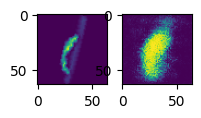

In [250]:
def show_img(model):
    index = random.randint(0,127)
    origin_img = torch.permute(fix_test[index],(1,2,0)).detach().cpu().numpy()
    reconstruct_img = model(fix_test[index].unsqueeze(0)).squeeze(0).permute((1,2,0)).detach().cpu().numpy()
    plt.figure(figsize=(2,2))
    plt.subplot(2,2,1)
    plt.imshow(origin_img)
    plt.subplot(2,2,2)
    plt.imshow(reconstruct_img)
    plt.show()
show_img(model)